## Options Liquidity


This notebook analyzes options LP return for various scenarios.


**Conclusion:**

First LPs in market tend to suffer losses. Later LPs tend to do well (assuming they deposit small amounts and only when prices are efficient).

So an LP vault should only deposit a small amount when a new market is created, then gradually drip in liquidity. It can probably be sustainable and profitable if it does this.

The strike prices for each market should be chosen in a narrow range, such as only 2k - 4k strikes for ETH. This will reduce the loss for the first LPs.

**👇Scroll down to see plots**

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

sns.set_style("white")

plt.rcParams['figure.dpi'] = 200
plt.rc("font", size=8)

In [102]:
# set params
b = 100  # value of b doesn't really matter

# we consider two ranges of strikes
wide_strikes = [480, 600, 960, 1280, 1600, 1920, 2560, 3200, 3840, 5000, 6000, 8000, 10000]
narrow_strikes = [2000, 2250, 2500, 2570, 3000, 3250, 3500, 3750, 4000]

n = len(strike_prices) + 1

In [28]:
# lmsr cost function
def lmsr(q, b):
    mx = q.max()
    a = np.exp((q-mx)/b).sum()
    return mx + b * np.log(a)


# grad of lmsr cost wrt q
def gradq(q, b):
    a = np.exp((q - q.max()) / b)
    return a / a.sum()


# partial derivative of lmsr cost wrt b
def db(q, b, eps=1e-9):
    return (lmsr(q, b+eps) - lmsr(q, b)) / eps

In [106]:
def calc_call_payoffs(underlying_price, strike_prices):
    lo = np.concatenate([[0], strike_prices])
    hi = np.concatenate([strike_prices, [np.inf]])
    return np.maximum(0, np.minimum(hi, underlying_price) - lo) / underlying_price


def calc_put_payoffs(underlying_price, strike_prices):
    lo = np.concatenate([[1e-9], strike_prices])
    hi = np.concatenate([strike_prices, [1e9]])
    a = np.maximum(0, lo - underlying_price) / lo
    b = np.maximum(0, hi - underlying_price) / hi
    return b - a


def calc_call_lp_payoff(underlying_price, strike_prices, b):
    payoff = calc_call_payoffs(underlying_price, strike_prices)
    q = calc_q(payoff, b)
    return lmsr(q, b) - (payoff * q).sum()


def calc_put_lp_payoff(underlying_price, strike_prices, b):
    payoff = calc_put_payoffs(underlying_price, strike_prices)
    q = calc_q(payoff, b)
    return lmsr(q, b) - (payoff * q).sum()


# calculate what q would be at expiry assuming market is efficient and no arbs exist at expiry
def calc_q(payoff, b):
    def loss(q):
        return ((gradq(q, b) - payoff) ** 2).sum()
    
    initial = np.ones(payoff.shape)
    q = minimize(loss, initial, tol=1e-9).x
    
    # normalize since LMSR is translation invariant
    return q - q.min()

In [115]:
# make plots look nice
def format_ax(ax):
    sns.despine(top=True, right=True, left=False, bottom=False)
    ax.grid(False)
    ax.spines['left'].set_color('#999999')
    ax.spines['bottom'].set_color('#999999')
    ax.xaxis.label.set_color('#666666')
    ax.yaxis.label.set_color('#666666')
    ax.tick_params(axis='x', colors='#666666', which='both')
    ax.tick_params(axis='y', colors='#666666', which='both')

    
def plot_lp_return(hedge, lp_type, strike_prices):
    x = np.linspace(200, 20000, num=20)
    lp_payoff = np.array([calc_call_lp_payoff(px, strike_prices, b) for px in x])
    hedge_payoff = np.array([(hedge * b * calc_call_payoffs(px, strike_prices)).sum() for px in x])
    
    if lp_type == "marginal":
        q0 = calc_q(calc_call_payoffs(initial_price, strike_prices), b)
        lp_cost = db(q0, b) * b
        hedge_cost = (gradq(q0, b) * hedge * b).sum()
        cost = lp_cost + hedge_cost
    
    elif lp_type == "seed":
        cost = lmsr(hedge * b, b)
    
    else:
        raise ValueError()
    
    lp_return = (lp_payoff + hedge_payoff) / cost
    lp_return_percent = lp_return * 100 - 100

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    format_ax(ax)
    ax.set_ylabel("Return")
    ax.set_xlabel("Underlying price at expiry")
    ax.plot(x, lp_return_percent)

### Unhedged seed LP

**Seed LPs** are the first LPs to deposit into a new market, before any trades or deposits have taken place

Plot below demonstrates seed LPs tend to lose at least 10% regardless of price. If price moves a lot either way, they lose more. This isn't great, but we show a way to mitigate this loss later on.

Return is in terms of the underlying asset and assumes a single deposit when the market is first created and that the deposit is held until expiration. Trading fees earned are not taken into account.

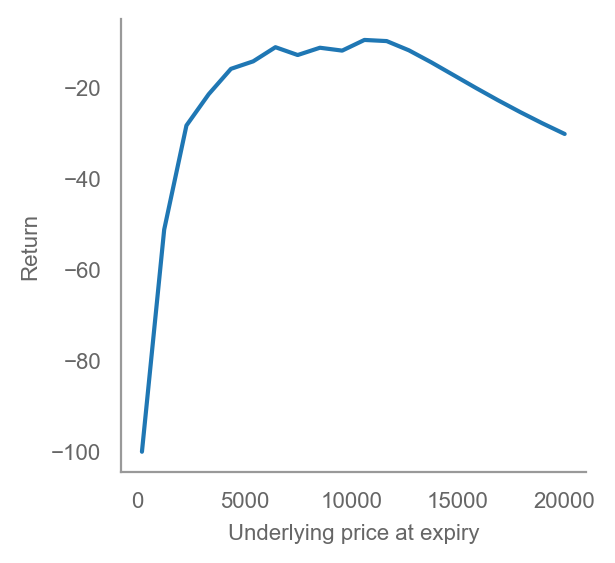

In [130]:
hedge = np.zeros(len(wide_strikes) + 1)
plot_lp_return(hedge, "seed", wide_strikes)

### Hedged seed LP

Even if seed LP hedges, they'll still lose around 20-30%. This is expected since they lose regardless without hedging.

Note that it's not possible to perfectly hedge. Options payoffs are piecewise linear but LP payoff is curved.

To hedge, 2.5 calls with the lowest strike and 1 call with the highest strike are bought for each LP share.

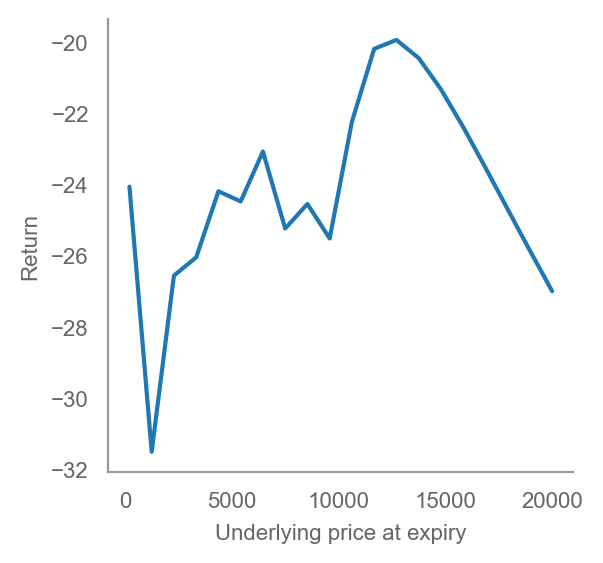

In [121]:
hedge = np.zeros(len(wide_strikes) + 1)
hedge[0] = 2.5
hedge[-1] = 1
plot_lp_return(hedge, "seed", wide_strikes)

### Hedged seed LP with narrow strike range
Now let's reduce the range of strikes offered by the market. Now they range from 2k - 4k instead of 480 - 10k (the current range for June options).

The loss is significantly reduced to around 5-15%. So a seed LP might make a profit, but this depends on how much trading fees are earned.

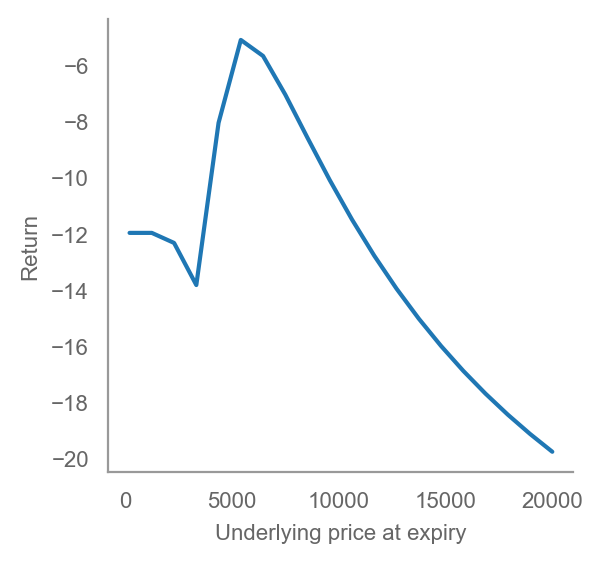

In [131]:
hedge = np.zeros(len(narrow_strikes) + 1)
hedge[0] = 3.5
hedge[-1] = 2.5
plot_lp_return(hedge, "seed", narrow_strikes)

### Unhedged marginal LP

Now let's look at **marginal LPs** - they tend to do way better.

Marginal LPs are LPs who deposit later on when the market is already in equilibrium - i.e. when prices are all efficient and where they should be. This also assumes they deposit a small amount and so do not suffer from slippage.

They lose if underlying moves a lot, but make a profit for a wide range of prices.

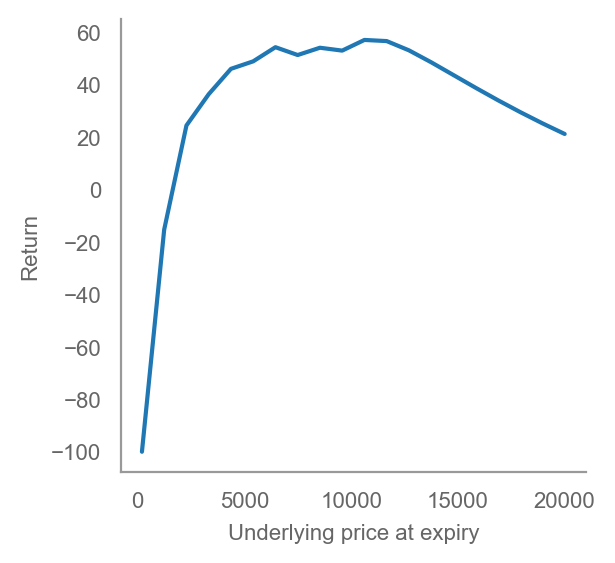

In [116]:
hedge = np.zeros(len(wide_strikes) + 1)
plot_lp_return(hedge, "marginal", wide_strikes)

### Hedged marginal LP

If a marginal LP hedges, it looks like they can make a profit of around 0 - 13% across most prices.

So the LP vault should always wait until prices become efficient before making further deposits.

When a market is created, the LP vault can only deposit a small amount (since seed liquidity has worse performance). It should wait until prices are efficient before depositing a bit more, and repeat this, gradually dripping in deposits.

This is really encouraging because it indicates being an LP can be sustainable and profitable.

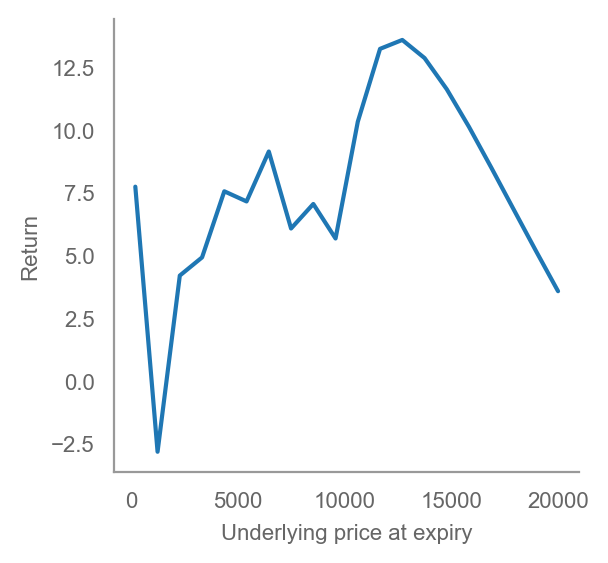

In [128]:
hedge = np.zeros(len(wide_strikes) + 1)
hedge[0] = 2.5
hedge[-1] = 1
plot_lp_return(hedge, "marginal", wide_strikes)